#RNN, LSTM, and Attention for Image Captioning

This is my implemntation of different models that serve same task - Image captioning, My inspiration for this project was Andrej Karpathy's [notes](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) on his first ever RNN so i decided to play with different models as well )))))

## Installing module
I will continue using some functions that was developed by research group of University of Michigan to help utilize PyTorch on low-level functionality: [`coutils` package](https://github.com/deepvision-class/starter-code).


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-akayvnq0
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-akayvnq0
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=8acfe89a0f3352ac56afb512eba2c2a0458f2394e1c1d44ad60207fda0b508c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3sb6mju/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Some setup code for this notebook: Importing some useful packages and increasing the default figure size.

In [ ]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, \
                    tensor_to_image, decode_captions, attention_visualizer
import matplotlib.pyplot as plt
import time

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Setting GPUs to accelerate computation in this notebook.

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Yay its turned off :(')

Good to go!


# Microsoft COCO
For this project I will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

I have preprocessed the data already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. 

I will later use MobileNet v2 to extract features for the images.



In [ ]:
# Downloading and loading serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (112x112)
# "val_images" - resized validation images (112x112)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
data_dict = torch.load('coco.pt')

# print out all the keys and values from the data dictionary
for k, v in data_dict.items():
    if type(v) == torch.Tensor:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), v.keys())

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)
assert data_dict['train_images'].size(0) == data_dict['train_captions'].size(0) and \
       data_dict['val_images'].size(0) == data_dict['val_captions'].size(0), \
       'shapes of data mismatch!'

print('\nTrain images shape: ', data_dict['train_images'].shape)
print('Train caption tokens shape: ', data_dict['train_captions'].shape)
print('Validation images shape: ', data_dict['val_images'].shape)
print('Validation caption tokens shape: ', data_dict['val_captions'].shape)
print('total number of caption tokens: ', len(data_dict['vocab']['idx_to_token']))
print('mappings (list) from index to caption token: ', data_dict['vocab']['idx_to_token'])
print('mappings (dict) from caption token to index: ', data_dict['vocab']['token_to_idx'])

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']

--2020-12-29 10:26:43--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘coco.pt’

coco.pt             100%[===================>] 378.21M  54.2MB/s    in 7.8s    

2020-12-29 10:26:51 (48.7 MB/s) - ‘coco.pt’ saved [396583632/396583632]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Si

## Exploring the data
It is always a good idea to look at examples from the dataset before working with it.

Sample of a small minibatch of training data and showing the images and their captions.

I decode the captions using the `decode_captions` function.

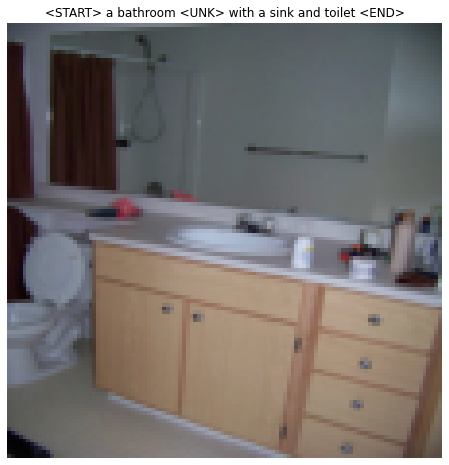

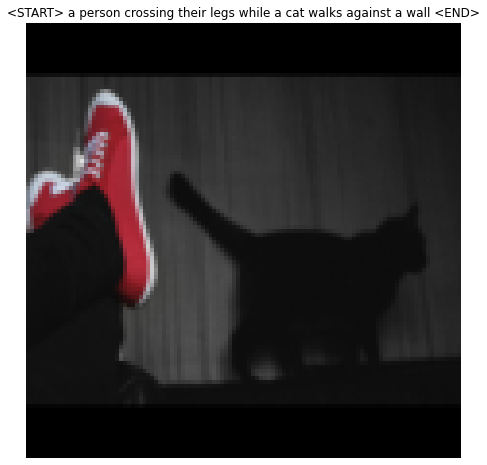

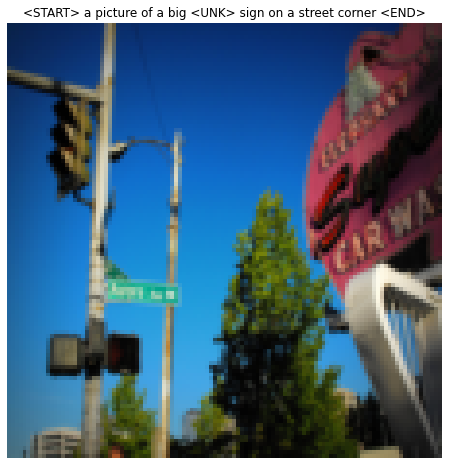

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# Recurrent Neural Networks
I will use Recurrent Neural Network (RNN) language models for image captioning. I will implement the vanilla RNN model first and later LSTM and attention-based language models.

## Vanilla RNN: step forward
First implementing the forward pass for a single timestep of a vanilla recurrent neural network.

In [ ]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Vanilla RNN that uses a tanh
    activation function.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h = torch.tanh(x.mm(Wx) + prev_h.mm(Wh) + b)
    cache = (x,Wx,prev_h,Wh,b,next_h)
    return next_h, cache

## Vanilla RNN: step backward
Implementing the backward pass for a single timestep of a vanilla recurrent neural network.

In [ ]:
def rnn_step_backward(dnext_h, cache):
    """
    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    x,Wx,prev_h,Wh,b,next_h = cache
    dout = dnext_h * (1 - next_h ** 2) # N,H
    dx = dout.mm(Wx.t()) # N,D = N,k * k,D
    dprev_h = dout.mm(Wh.t()) # N,H = N,k * k,H
    dWx = x.t().mm(dout) # D,H = D,k * k,H
    dWh = prev_h.t().mm(dout) # H,H = H,k * k,H
    db = dout.sum(dim=0)

    return dx, dprev_h, dWx, dWh, db

## Vanilla RNN: forward
Combining pieces to implement a RNN that processes an entire sequence of data.

In [ ]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    N,T,D = x.shape
    H = h0.shape[1]
    h = torch.zeros((N,T,H),dtype=h0.dtype,device=h0.device)
    prev_h = h0
    cache = []
    for i in range(T):
        next_h,cache_h = rnn_step_forward(x[:,i,:],prev_h,Wx,Wh,b)
        prev_h = next_h
        h[:,i,:] = prev_h
        cache.append(cache_h)

    return h, cache

## Vanilla RNN: backward
Implementation the backward pass for a vanilla RNN.

In [ ]:
def rnn_backward(dh, cache):
    """
    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H). 
    
    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    N,T,H = dh.shape
    D = cache[0][0].shape[1] #shape of dx
    dx = torch.zeros((N,T,D),dtype=cache[0][0].dtype,device=cache[0][0].device)
    dWx = torch.zeros_like(cache[0][1])
    dprev_h = torch.zeros_like(cache[0][2])
    dWh = torch.zeros_like(cache[0][3])
    db = torch.zeros_like(cache[0][4])
    dh0 = torch.zeros((N, H), dtype=dprev_h.dtype, device=dprev_h.device)
    dprev_h_ = torch.zeros_like(dh0)
    for i in range(T-1,-1,-1):
      dx_, dprev_h_, dWx_, dWh_, db_ = rnn_step_backward(dh[:,i,:]+dprev_h_, cache[i])
      dx[:, i, :] = dx_
      dWx += dWx_ # sum up because they share
      dWh += dWh_
      db += db_
    dh0 = dprev_h_

    return dx, dh0, dWx, dWh, db

## Vanilla RNN: backward with autograd
Now I need to compare the manual backward pass with the autograd backward pass using **automatic differentiation engine**.

In [ ]:
fix_random_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double_cuda, requires_grad=True)
h0 = torch.randn(N, H, **to_double_cuda, requires_grad=True)
Wx = torch.randn(D, H, **to_double_cuda, requires_grad=True)
Wh = torch.randn(H, H, **to_double_cuda, requires_grad=True)
b = torch.randn(H, **to_double_cuda, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# manual backward
with torch.no_grad():
  dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# backward with autograd
out.backward(dout) # the magic happens here!
dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = \
  x.grad, h0.grad, Wx.grad, Wh.grad, b.grad

print('dx error: ', rel_error(dx_auto, dx))
print('dh0 error: ', rel_error(dh0_auto, dh0))
print('dWx error: ', rel_error(dWx_auto, dWx))
print('dWh error: ', rel_error(dWh_auto, dWh))
print('db error: ', rel_error(db_auto, db))

dx error:  9.455508398529566e-15
dh0 error:  2.9841679001905593e-16
dWx error:  2.5341134542838853e-15
dWh error:  3.860601058262072e-15
db error:  6.634157791800413e-16


## RNN Module
Now wrap the vanilla RNN we wrote into an `nn.Module`.

Here I will set up a module for RNN, where function `__init__` sets up weight and biases, and function `forward` call the `rnn_forward` function from before.

All the next steps of implementation will be with `autograd` and `nn.Module` going forward.

In [ ]:
class RNN(nn.Module):
  """
  A single-layer vanilla RNN module.
  
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a RNN.
    Model parameters to initialize:
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size,
                       device=device, dtype=dtype))
    
  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn, _ = rnn_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn
  
  def step_forward(self, x, prev_h):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    """
    next_h, _ = rnn_step_forward(x, prev_h, self.Wx, self.Wh, self.b)
    return next_h

# RNN for image captioning
Next I will implement a few necessary tools and layers in order to build an image captioning model (class `CaptioningRNN`) Using RNN.

## Image Feature Extraction
Here, I used [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. For vanilla RNN and LSTM, I use the pooled CNN feature activation. For Attention LSTM, I will use the CNN feature activation map after the last convolution layer.

In [ ]:
# !pip install torchsummary

class FeatureExtractor(object):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, pooling=False, verbose=False,
               device='cpu', dtype=torch.float32):

    from torchvision import transforms, models
    from torchsummary import summary
    self.preprocess = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    self.device, self.dtype = device, dtype
    self.mobilenet = models.mobilenet_v2(pretrained=True).to(device)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier
    
    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(4, 4)) # input: N x 1280 x 4 x 4
    
    self.mobilenet.eval()
    if verbose:
      summary(self.mobilenet, (3, 112, 112))
  
  def extract_mobilenet_feature(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape N x 3 x 112 x 112

    Outputs:
    - feat: Image feature, of shape N x 1280 (pooled) or N x 1280 x 4 x 4
    """
    num_img = img.shape[0]
    
    img_prepro = []
    for i in range(num_img):
      img_prepro.append(self.preprocess(img[i].type(self.dtype).div(255.)))
    img_prepro = torch.stack(img_prepro).to(self.device)
    
    with torch.no_grad():
      feat = []
      process_batch = 500
      for b in range(math.ceil(num_img/process_batch)):
        feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                                ).squeeze(-1).squeeze(-1)) # forward and squeeze
      feat = torch.cat(feat)
      
      # add l2 normalization
      F.normalize(feat, p=2, dim=1)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

Now, exploring what's inside MobileNet v2. Assuming a 3x112x112 image input. I pass argument `pooling=True` to the model so the CNN activation is spatially-pooled from `1280x4x4` to `1280`.

In [ ]:
model = FeatureExtractor(pooling=True, verbose=True, device='cuda')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96

## Word embedding
In deep learning systems, It is common to represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

I Implemented the module `WordEmbedding` to convert words (represented by integers) into vectors.

In [ ]:
class WordEmbedding(nn.Module):
  """
  Simplified version of torch.nn.Embedding.

  Model operates on minibatches of size N where
  each sequence has length T. Assuming a vocabulary of V words, assigning each
  word to a vector of dimension D.

  Inputs:
  - x: Integer array of shape (N, T) giving indices of words. Each element idx
    of x muxt be in the range 0 <= idx < V.

  Returns a tuple of:
  - out: Array of shape (N, T, D) giving word vectors for all input words.
  """
  def __init__(self, vocab_size, embed_size,
               device='cpu', dtype=torch.float32):
      super().__init__()
      
      # Register parameters
      self.W_embed = Parameter(torch.randn(vocab_size, embed_size,
                         device=device, dtype=dtype).div(math.sqrt(vocab_size)))
      
  def forward(self, x):

      out = self.W_embed[x]
      return out

## Temporal Softmax loss
In an RNN language model, at every timestep It produces a score for each word in the vocabulary. I get the ground-truth word at each timestep, so I use a softmax loss function to compute loss and gradient at each timestep. Then I sum the losses over time and average them over the minibatch.

However there is one wrinkle: since it operates over minibatches and different captions may have different lengths, I append `<NULL>` tokens to the end of each caption so they all have the same length. I don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels my loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

In [ ]:
def temporal_softmax_loss(x, y, ignore_index=NULL_index):
    """
    A temporal version of softmax loss for use in RNNs. Assuming that I am
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. I use a cross-entropy loss at each
    timestep, *summing* the loss over all timesteps and *averaging* across the
    minibatch.

    As an additional complication, I may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional ignore_index argument
    tells us which elements in the caption should not contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V

    Returns a tuple of:
    - loss: Scalar giving loss
    """
    loss = F.cross_entropy(x.reshape(-1,x.shape[2]),y.reshape(-1,),reduction='sum',ignore_index=ignore_index)/x.shape[0]

    return loss

## Captioning Module
Now I am wrapping everything into the captioning module. Implementing the `__init__` function for initialization and the `captioning_forward` for the forward pass. For now I only implement for the case where `cell_type='rnn'`, indicating vanialla RNNs; I will implement the `LSTM` case and `AttentionLSTM` case later.

In [ ]:
class CaptioningRNN(nn.Module):
    """
    A CaptioningRNN produces captions from images using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    I don't use any regularization for the CaptioningRNN.
    """
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', device='cpu', dtype=torch.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        super().__init__()
        if cell_type not in {'rnn', 'lstm', 'attention'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)
        self.device = device
        self.dtype = dtype
        CNN_H0_Affine_W = torch.randn(hidden_dim, input_dim,
                       device=device, dtype=dtype).div(math.sqrt(input_dim))
        CNN_H0_Affine_b = torch.zeros(hidden_dim, device=device, dtype=dtype)
        self.CNN_H0_Affine = nn.Linear(input_dim, hidden_dim).to(device).to(dtype)
        self.CNN_H0_Affine.weight.data.copy_(CNN_H0_Affine_W)
        self.CNN_H0_Affine.bias.data.copy_(CNN_H0_Affine_b)

        # Initialize word vectors
        self.wordEmbedding = WordEmbedding(vocab_size, wordvec_dim,  device=device, dtype=dtype)

        # Initialize output to vocab weights
        H_Prob_Affine_W = torch.randn( vocab_size, hidden_dim,
                       device=device, dtype=dtype).div(math.sqrt(hidden_dim))
        H_Prob_Affine_b = torch.zeros(vocab_size, device=device, dtype=dtype)
        self.H_Prob_Affine = nn.Linear(hidden_dim, vocab_size).to(device).to(dtype)
        self.H_Prob_Affine.weight.data.copy_(H_Prob_Affine_W)
        self.H_Prob_Affine.bias.data.copy_(H_Prob_Affine_b)

        if cell_type == 'rnn':
          self.rnn = RNN(input_size=wordvec_dim, hidden_size=hidden_dim, device=device, dtype=dtype)
          self.featureExtractor = FeatureExtractor(pooling=True, device=device, dtype=dtype)
        if cell_type == 'lstm':
          self.lstm= LSTM(input_size=wordvec_dim, hidden_size=hidden_dim, device=device, dtype=dtype)
          self.featureExtractor = FeatureExtractor(pooling=True, device=device, dtype=dtype)
        if cell_type == 'attention':
          Features_A_Affine_W = torch.randn( hidden_dim, input_dim,
                       device=device, dtype=dtype).div(math.sqrt(input_dim))
          Features_A_Affine_b = torch.zeros(hidden_dim, device=device, dtype=dtype)
          self.Features_A_Affine = nn.Linear(input_dim, hidden_dim).to(device).to(dtype)
          self.Features_A_Affine.weight.data.copy_(Features_A_Affine_W)
          self.Features_A_Affine.bias.data.copy_(Features_A_Affine_b)

          self.attentionLSTM=AttentionLSTM(input_size=wordvec_dim, hidden_size=hidden_dim, device=device, dtype=dtype)
          self.featureExtractor = FeatureExtractor(pooling=False, device=device, dtype=dtype)
          
    def forward(self):
      raise NotImplementedError
    
    def sample(self):
      raise NotImplementedError

### Forward part
Implementing the forward function.

In [ ]:
    def captioning_forward(self, images, captions):
        """
        Compute training-time loss for the RNN. We input images and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss. The backward part will be done by torch.autograd.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - captions: Ground-truth captions; an integer array of shape (N, T + 1) where
          each element is in the range 0 <= y[i, t] < V

        Outputs:
        - loss: A scalar loss
        """
        # Cutting captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what I will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        loss = 0.0
        features = self.featureExtractor.extract_mobilenet_feature(images)
      
        in_word_vectors =  self.wordEmbedding.forward(captions_in)

        if self.cell_type == 'rnn':
          h0 = self.CNN_H0_Affine(features)
          H = self.rnn.forward(in_word_vectors,h0)
        elif self.cell_type == 'lstm':
          h0 = self.CNN_H0_Affine(features)
          H = self.lstm.forward(in_word_vectors,h0)
        else:
          A = self.Features_A_Affine(features.permute(0,2,3,1)).permute(0,3,1,2) #FIX: features
          H = self.attentionLSTM.forward(in_word_vectors,A) 
        
        Probs = self.H_Prob_Affine(H)
        loss = temporal_softmax_loss(Probs,captions_out)

        return loss

    CaptioningRNN.forward = captioning_forward

### Inference part


In [ ]:
    def sample_caption(self, images, max_length=15):
        """
        Running a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, I embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the image features, and the initial word is the <START>
        token.

        For LSTMs I will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - max_length: Maximum length T of generated captions

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = images.shape[0]
        captions = self._null * images.new(N, max_length).fill_(1).long()

        if self.cell_type == 'attention':
          attn_weights_all = images.new(N, max_length, 4, 4).fill_(0).float()

        features = self.featureExtractor.extract_mobilenet_feature(images)
        start_idx = torch.zeros(N).fill_(self._start).long()
        x = self.wordEmbedding.forward(start_idx)
        if self.cell_type == 'attention':
          A = self.Features_A_Affine(features.permute(0,2,3,1)).permute(0,3,1,2)
          h = A.mean(dim=(2, 3)) # initialize h0 for lstm attention
          c = h # initialize c0 for lstm attention
        else:
          h = self.CNN_H0_Affine(features) # initialize h0 for rnn & lstm
        if self.cell_type == 'lstm':
          c = torch.zeros_like(h) # initialize c0 for lstm
        

        for i in range(max_length):
          if self.cell_type == 'rnn':
            next_h = self.rnn.step_forward(x,h)
          elif self.cell_type == 'lstm':
            next_h,c = self.lstm.step_forward(x,h,c)
          else:
            attn, attn_weights_all[:,i,:,:] = dot_product_attention(h, A)
            next_h,c = self.attentionLSTM.step_forward(x,h,c,attn)
          Probs = self.H_Prob_Affine(next_h)
          h = next_h # update h
          max_idx= torch.max(Probs,1)[1]
          captions[:,i] = max_idx
          x = self.wordEmbedding.forward(max_idx)

        if self.cell_type == 'attention':
          return captions, attn_weights_all.cpu()
        else:
          return captions

    CaptioningRNN.sample = sample_caption

## Image Captioning training

In [ ]:
def CaptioningTrain(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):

  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

## Overfitting small amount of data to ensure that 
## I Implemented everything correctly


learning rate is:  0.001
(Epoch 0 / 80) loss: 76.0101 time per epoch: 0.0s
(Epoch 1 / 80) loss: 68.0679 time per epoch: 0.0s
(Epoch 2 / 80) loss: 61.8547 time per epoch: 0.0s
(Epoch 3 / 80) loss: 55.7462 time per epoch: 0.0s
(Epoch 4 / 80) loss: 50.3842 time per epoch: 0.0s
(Epoch 5 / 80) loss: 46.2102 time per epoch: 0.0s
(Epoch 6 / 80) loss: 43.2662 time per epoch: 0.0s
(Epoch 7 / 80) loss: 40.8927 time per epoch: 0.0s
(Epoch 8 / 80) loss: 38.7858 time per epoch: 0.0s
(Epoch 9 / 80) loss: 36.7571 time per epoch: 0.0s
(Epoch 10 / 80) loss: 35.0253 time per epoch: 0.0s
(Epoch 11 / 80) loss: 33.2069 time per epoch: 0.0s
(Epoch 12 / 80) loss: 31.7267 time per epoch: 0.0s
(Epoch 13 / 80) loss: 30.3661 time per epoch: 0.0s
(Epoch 14 / 80) loss: 31.8390 time per epoch: 0.0s
(Epoch 15 / 80) loss: 28.4148 time per epoch: 0.0s
(Epoch 16 / 80) loss: 27.4570 time per epoch: 0.0s
(Epoch 17 / 80) loss: 25.5425 time per epoch: 0.0s
(Epoch 18 / 80) loss: 24.9984 time per epoch: 0.0s
(Epoch 19 / 80) 

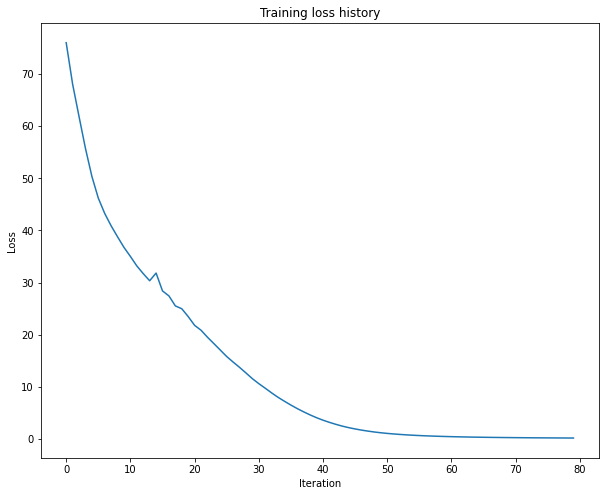

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50
  
# create the image captioning model
model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, It has access to the ground-truth caption, so I feed ground-truth words as input to the RNN at each timestep. At test time, It samples from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.


### Now I will Train the model


learning rate is:  0.001
(Epoch 0 / 60) loss: 46.4220 time per epoch: 5.1s
(Epoch 1 / 60) loss: 40.2949 time per epoch: 5.1s
(Epoch 2 / 60) loss: 36.8569 time per epoch: 5.2s
(Epoch 3 / 60) loss: 33.8791 time per epoch: 5.3s
(Epoch 4 / 60) loss: 31.7226 time per epoch: 5.2s
(Epoch 5 / 60) loss: 29.4964 time per epoch: 5.2s
(Epoch 6 / 60) loss: 27.5263 time per epoch: 5.3s
(Epoch 7 / 60) loss: 25.8599 time per epoch: 5.3s
(Epoch 8 / 60) loss: 24.1550 time per epoch: 5.3s
(Epoch 9 / 60) loss: 22.7376 time per epoch: 5.2s
(Epoch 10 / 60) loss: 21.4011 time per epoch: 5.2s
(Epoch 11 / 60) loss: 19.9754 time per epoch: 5.3s
(Epoch 12 / 60) loss: 18.8531 time per epoch: 5.2s
(Epoch 13 / 60) loss: 17.7245 time per epoch: 5.2s
(Epoch 14 / 60) loss: 16.6491 time per epoch: 5.2s
(Epoch 15 / 60) loss: 15.4568 time per epoch: 5.4s
(Epoch 16 / 60) loss: 14.4638 time per epoch: 5.1s
(Epoch 17 / 60) loss: 13.5345 time per epoch: 5.2s
(Epoch 18 / 60) loss: 12.4992 time per epoch: 5.2s
(Epoch 19 / 60) 

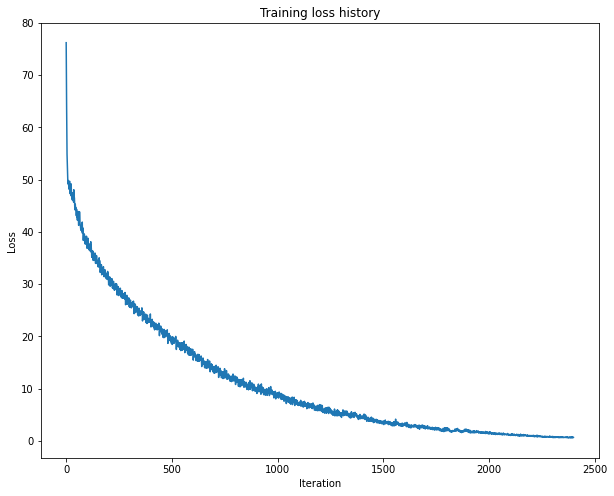

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, 
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
The samples on training data should be very good; the samples on validation data will probably make less sense.

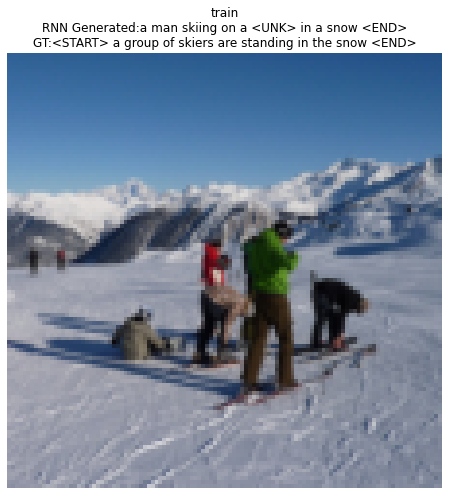

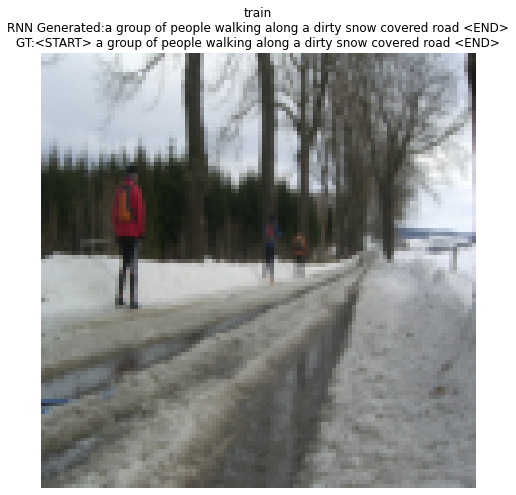

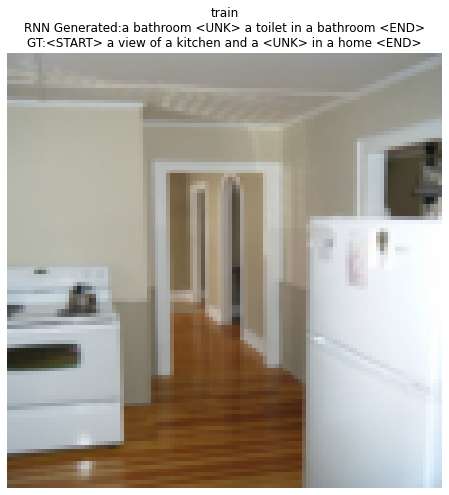

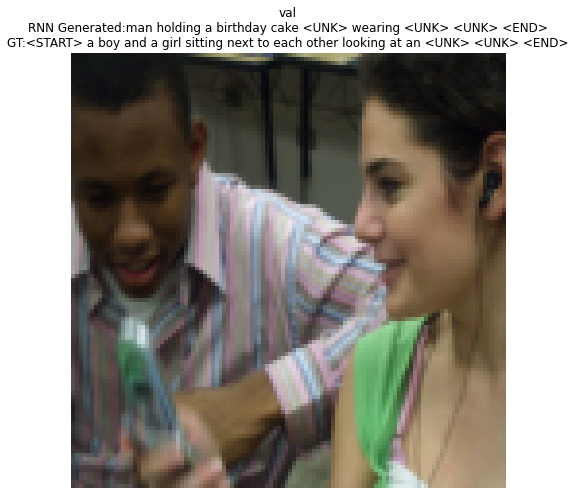

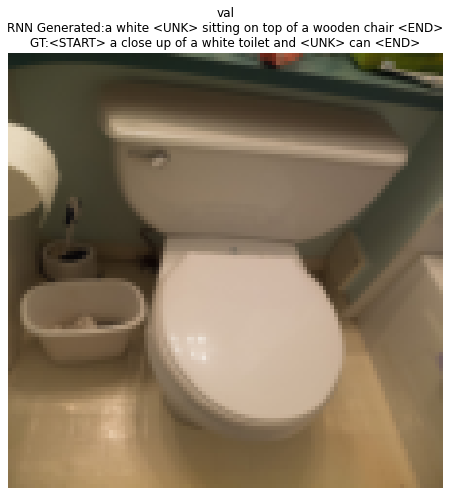

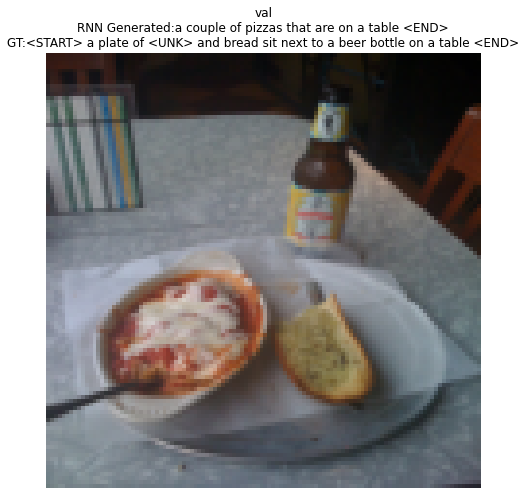

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by my model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Image Captioning with LSTMs
Next, I will implement the LSTM update rule and use it for same task, image captioning.

# LSTM
When I read recent papers, I see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs because Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep It receives an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so it also receives the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep I will first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. Then I will divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. Next I will compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally I will compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook I will implement the LSTM update rule and apply it to the image captioning task. 

In the code, my data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and I will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

## LSTM: step forward
Implementing the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function. This will be similar to the `rnn_step_forward` function that I implemented above, but using the LSTM update rule instead.

I will use AMAZING `autograd` to handle backward pass.

In [ ]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b, attn=None, Wattn=None):
    """
    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    - attn and Wattn are for Attention LSTM only, indicate the attention input and
      embedding weights for the attention input

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    """
    N, H = prev_h.shape
    a = None
    if attn is None: # regular lstm
      a = x.mm(Wx) + prev_h.mm(Wh) + b
    else:
      a = x.mm(Wx) + prev_h.mm(Wh) + b + attn.mm(Wattn)
    i = torch.sigmoid(a[:,0:H])
    f = torch.sigmoid(a[:,H:2*H])
    o = torch.sigmoid(a[:,2*H:3*H])
    g = torch.tanh(a[:,3*H:4*H])
    next_c = f * prev_c + i * g
    next_h = o * torch.tanh(next_c)

    return next_h, next_c

## LSTM: forward
Implementing the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

Again, I will use lovely `autograd` to handle backprop.

In [ ]:
def lstm_forward(x, h0, Wx, Wh, b):
    """
    Inputs:
    - x: Input data, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    """
    c0 = torch.zeros_like(h0) # I create the intial cell state c0!
    N, T, D = x.shape
    _, H = h0.shape
    h = torch.zeros((N, T, H), dtype=h0.dtype, device=h0.device)
    prev_h = h0
    prev_c = c0
    for i in range(T):
      next_h, next_c = lstm_step_forward(x[:,i,:], prev_h, prev_c, Wx, Wh, b)
      prev_h = next_h
      prev_c = next_c
      h[:, i, :] = prev_h

    return h

## LSTM Module

Now I will wrap the LSTM functions I wrote into an nn.Module.

In [ ]:
class LSTM(nn.Module):
  """
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a LSTM.
    Model parameters to initialize:
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size*4,
                       device=device, dtype=dtype))
    
  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn = lstm_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn
  
  def step_forward(self, x, prev_h, prev_c):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)
    - prev_c: The previous cell state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    - next_c: The next cell state, of shape (N, H)
    """
    next_h, next_c = lstm_step_forward(x, prev_h, prev_c, self.Wx, self.Wh, self.b)
    return next_h, next_c

## LSTM captioning model

Now that I have implemented an LSTM, update the implementation of the [`init`](#scrollTo=XWrmaSZaUxqX) method in class `CaptioningRNN` **ONLY** to also handle the case where `self.cell_type` is `lstm`. 


##Again Overfitting small data to ensure that I Implemented it correct


learning rate is:  0.01
(Epoch 0 / 80) loss: 74.9722 time per epoch: 0.0s
(Epoch 1 / 80) loss: 70.2986 time per epoch: 0.0s
(Epoch 2 / 80) loss: 50.6434 time per epoch: 0.0s
(Epoch 3 / 80) loss: 51.6769 time per epoch: 0.0s
(Epoch 4 / 80) loss: 49.0342 time per epoch: 0.0s
(Epoch 5 / 80) loss: 46.6563 time per epoch: 0.0s
(Epoch 6 / 80) loss: 45.0053 time per epoch: 0.0s
(Epoch 7 / 80) loss: 43.7405 time per epoch: 0.1s
(Epoch 8 / 80) loss: 41.6743 time per epoch: 0.0s
(Epoch 9 / 80) loss: 39.5250 time per epoch: 0.0s
(Epoch 10 / 80) loss: 37.4432 time per epoch: 0.0s
(Epoch 11 / 80) loss: 35.4612 time per epoch: 0.0s
(Epoch 12 / 80) loss: 33.6318 time per epoch: 0.0s
(Epoch 13 / 80) loss: 31.7107 time per epoch: 0.0s
(Epoch 14 / 80) loss: 29.7267 time per epoch: 0.0s
(Epoch 15 / 80) loss: 27.5919 time per epoch: 0.0s
(Epoch 16 / 80) loss: 25.2861 time per epoch: 0.0s
(Epoch 17 / 80) loss: 22.9362 time per epoch: 0.0s
(Epoch 18 / 80) loss: 20.8002 time per epoch: 0.0s
(Epoch 19 / 80) l

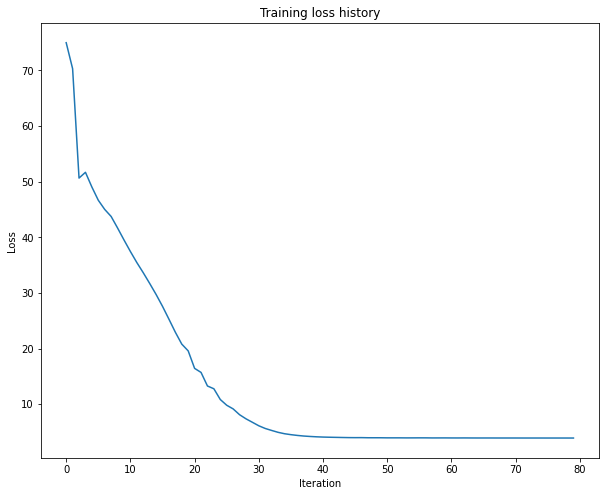

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, 
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-2]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Train the net
Now, I will perform the training on the entire training set. 

learning rate is:  0.001
(Epoch 0 / 60) loss: 48.5411 time per epoch: 5.8s
(Epoch 1 / 60) loss: 42.5079 time per epoch: 5.8s
(Epoch 2 / 60) loss: 39.0414 time per epoch: 5.7s
(Epoch 3 / 60) loss: 37.0634 time per epoch: 5.9s
(Epoch 4 / 60) loss: 35.0310 time per epoch: 5.8s
(Epoch 5 / 60) loss: 33.0742 time per epoch: 5.8s
(Epoch 6 / 60) loss: 31.4146 time per epoch: 5.8s
(Epoch 7 / 60) loss: 30.0297 time per epoch: 5.7s
(Epoch 8 / 60) loss: 28.7025 time per epoch: 5.7s
(Epoch 9 / 60) loss: 27.3948 time per epoch: 5.7s
(Epoch 10 / 60) loss: 26.1433 time per epoch: 5.8s
(Epoch 11 / 60) loss: 24.9778 time per epoch: 5.8s
(Epoch 12 / 60) loss: 23.7455 time per epoch: 5.7s
(Epoch 13 / 60) loss: 22.8589 time per epoch: 5.8s
(Epoch 14 / 60) loss: 21.7638 time per epoch: 5.7s
(Epoch 15 / 60) loss: 20.4632 time per epoch: 5.8s
(Epoch 16 / 60) loss: 19.5517 time per epoch: 5.9s
(Epoch 17 / 60) loss: 18.8914 time per epoch: 5.8s
(Epoch 18 / 60) loss: 17.7484 time per epoch: 5.8s
(Epoch 19 / 60) 

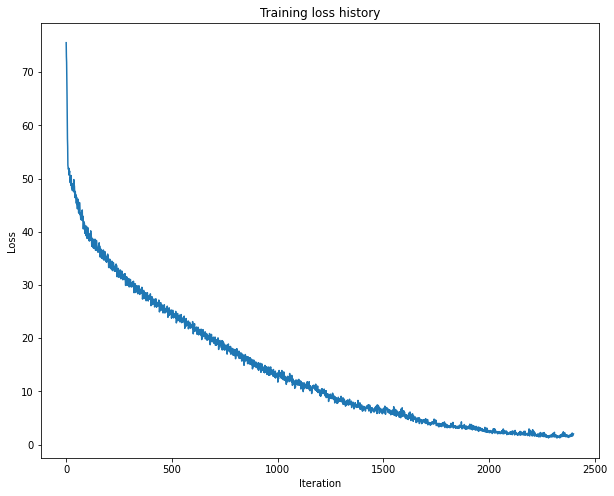

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(lstm_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
As with the RNN, the samples on training data should be very good; the samples on validation data will probably make less sense.

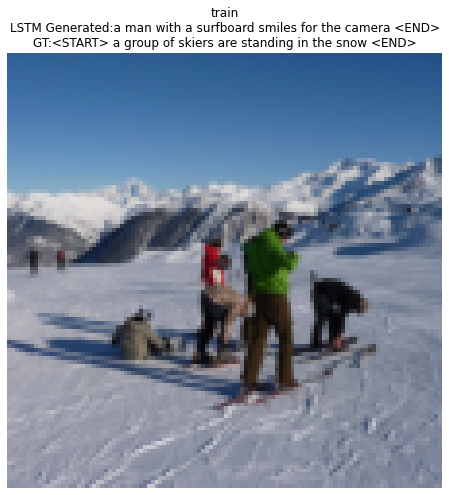

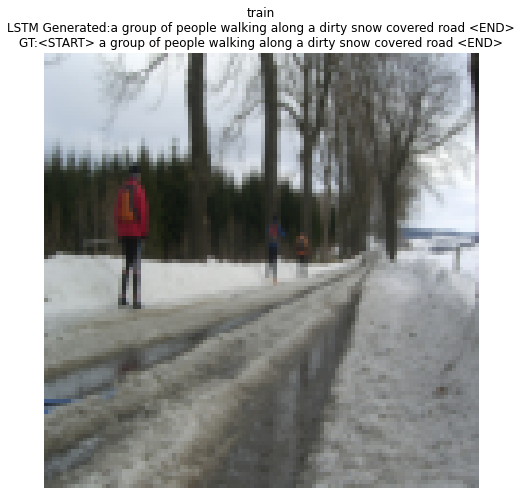

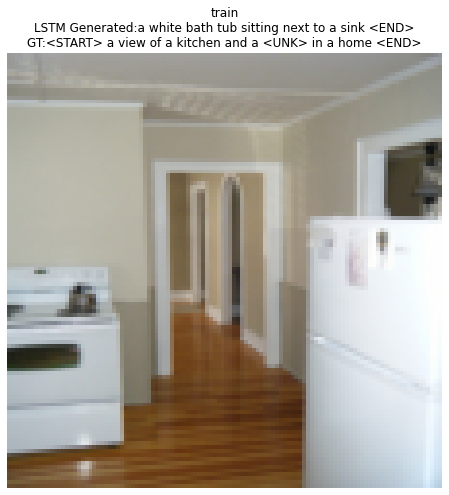

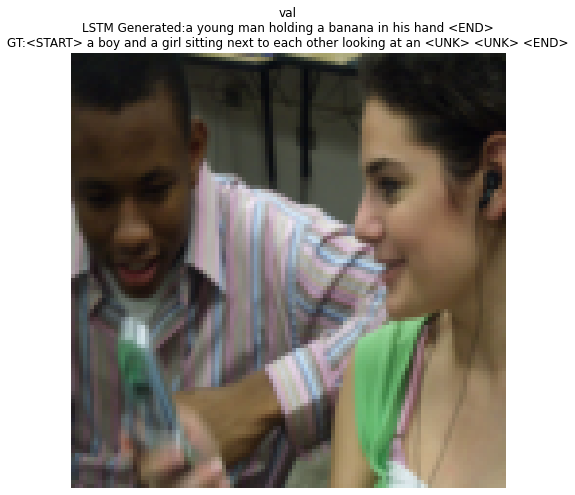

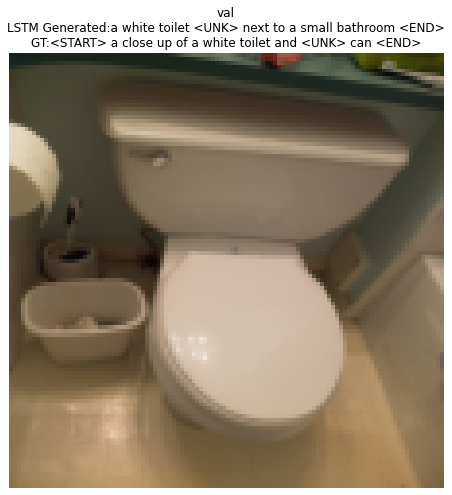

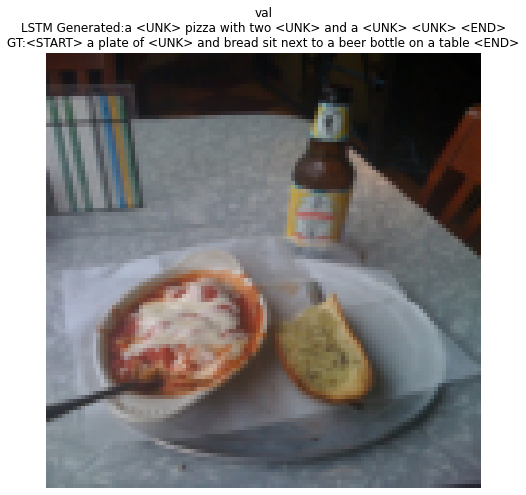

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  lstm_model.eval()
  generated_captions = lstm_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nLSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

# Attention LSTM
Attention LSTM essentially adds an attention input $x_{attn}^t\in\mathbb{R}^H$ into LSTM, along with $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$.

To get the attention input $x_{attn}^t$, here I adopt a method called `scaled dot-product attention`, as covered in the lecture. I first project the CNN feature activation from $\mathbb{R}^{1280\times4\times4}$ to $\mathbb{R}^{H\times4\times4}$ using an affine layer. Given the projected activation $A\in \mathbb{R}^{H\times4\times4}$ and the LSTM hidden state from the previous time step $h_{t-1}$, I formuate the attention weights on $A$ at time step $t$ as $M_{attn}^t=h_{t-1}A/\sqrt{H} \in \mathbb{R}^{4\times4}$.

To simplify the formuation here, I flatten the spatial dimensions of $A$ and $M_{attn}^t$ which gives $\tilde{A}\in \mathbb{R}^{H\times16}$ and $\tilde{M^t}_{attn}=h_{t-1}A\in \mathbb{R}^{16}$.
We add a **`softmax`** activation function on $\tilde{M^t}_{attn}$ so that the attention weights at each time step are normalized and sum up to one.

The attention embedding given the attention weights is then $x_{attn}^t=\tilde{A}\tilde{M^t}_{attn} \in\mathbb{R}^H$.


## Scaled dot-product attention
Implementing the scaled dot-product attention function. Given the LSTM hidden state from the previous time step `prev_h` (or $h_{t-1}$) and the projected CNN feature activation `A`,I will compute the attention weights `attn_weights` (or $\tilde{M^t}_{attn}$ with a reshaping to $\mathbb{R}^{4\times4}$) attention embedding output `attn` (or $x_{attn}^t$).

In [ ]:
def dot_product_attention(prev_h, A):
    """
    A simple scaled dot-product attention layer.
    Inputs:
    - prev_h: The LSTM hidden state from the previous time step, of shape (N, H)
    - A: **Projected** CNN feature activation, of shape (N, H, 4, 4),
         where H is the LSTM hidden state size
    
    Outputs:
    - attn: Attention embedding output, of shape (N, H)
    - attn_weights: Attention weights, of shape (N, 4, 4)
    
    """
    N, H, D_a, _ = A.shape

    Mt = torch.matmul(prev_h.view(N,1,H),A.view(N,H,4*4)).squeeze(1).div(H**0.5) #(N,16)
    attn_weights = F.softmax(Mt,dim=1) #(N,16)
    attn = torch.matmul(A.view(N,H,4*4), attn_weights.view(N,4*4,1)).squeeze(2) #(N,H)
    attn_weights = attn_weights.view(N,4,4) #(N,4,4)

    return attn, attn_weights

## Attention LSTM: step forward

I will simply modify the [`lstm_step_forward`](#scrollTo=t4DNkZYevMMc) function from earlier to support the extra attention input `attn` (or $x_{attn}$) and its embedding weight matrix `Wattn` (or $W_{attn}$) in the LSTM cell. Hence, at each timestep the *activation vector* $a\in\mathbb{R}^{4H}$ in LSTM cell is formulated as:

$a=W_xx_t + W_hh_{t-1}+W_{attn}x_{attn}^t+b$.


## Attention LSTM: forward


Now, I will implement the `attention_forward` function to run an Attention LSTM forward on an entire timeseries of data. I will use the `dot_product_attention` function and the `lstm_step_forward` function I already implemented.

Again, `autograd` will handle backward (I like that :)).

In [ ]:
def attention_forward(x, A, Wx, Wh, Wattn, b):
    """
    h0 and c0 are same initialized as the global image feature (meanpooled A)
    For simplicity, I implement scaled dot-product attention, which means in
    Eq. 4 of the paper (https://arxiv.org/pdf/1502.03044.pdf),
    f_{att}(a_i, h_{t−1}) equals to the scaled dot product of a_i and h_{t-1}.

    Inputs:
    - x: Input data, of shape (N, T, D)
    - A: **Projected** activation map, of shape (N, H, 4, 4)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - Wattn: Weights for attention-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    """

    # The initial hidden state h0 and cell state c0 are initialized differently in
    # Attention LSTM from the original LSTM and hence I predefined it.
    h0 = A.mean(dim=(2, 3)) # Initial hidden state, of shape (N, H)
    c0 = h0 # Initial cell state, of shape (N, H)
    N, T, D = x.shape
    _, H = h0.shape
    h = torch.zeros((N, T, H), dtype=h0.dtype, device=h0.device)
    prev_h = h0
    prev_c = c0
    for i in range(T):
      attn, attn_weights = dot_product_attention(prev_h, A)
      next_h, next_c = lstm_step_forward(x[:,i,:], prev_h, prev_c, Wx, Wh, b, attn=attn, Wattn=Wattn)
      prev_h = next_h
      prev_c = next_c
      h[:, i, :] = prev_h

    return h

## Attention LSTM Module
Now I will wrap the Attention LSTM functions I wrote into an nn.Module.

In [ ]:
class AttentionLSTM(nn.Module):
  """
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a LSTM.
    Model parameters to initialize:
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - Wattn: Weights for attention-to-hidden connections, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.Wattn = Parameter(torch.randn(hidden_size, hidden_size*4,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size*4,
                       device=device, dtype=dtype))
    
  def forward(self, x, A):
    """  
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - A: The projected CNN feature activation, of shape (N, H, 4, 4)

    Outputs:
    - hn: The hidden state output
    """
    hn = attention_forward(x, A, self.Wx, self.Wh, self.Wattn, self.b)
    return hn
  
  def step_forward(self, x, prev_h, prev_c, attn):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)
    - prev_c: The previous cell state, of shape (N, H)
    - attn: The attention embedding, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    - next_c: The next cell state, of shape (N, H)
    """
    next_h, next_c = lstm_step_forward(x, prev_h, prev_c, self.Wx, self.Wh,
                                       self.b, attn=attn, Wattn=self.Wattn)
    return next_h, next_c

## Overfitting small amount of data to check my implementation

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.2449 time per epoch: 0.0s
(Epoch 1 / 80) loss: 64.8593 time per epoch: 0.1s
(Epoch 2 / 80) loss: 57.0488 time per epoch: 0.0s
(Epoch 3 / 80) loss: 51.3897 time per epoch: 0.0s
(Epoch 4 / 80) loss: 48.4411 time per epoch: 0.0s
(Epoch 5 / 80) loss: 45.0080 time per epoch: 0.0s
(Epoch 6 / 80) loss: 42.6969 time per epoch: 0.1s
(Epoch 7 / 80) loss: 40.3514 time per epoch: 0.0s
(Epoch 8 / 80) loss: 38.3962 time per epoch: 0.0s
(Epoch 9 / 80) loss: 36.5133 time per epoch: 0.0s
(Epoch 10 / 80) loss: 34.6947 time per epoch: 0.0s
(Epoch 11 / 80) loss: 33.2602 time per epoch: 0.0s
(Epoch 12 / 80) loss: 31.6609 time per epoch: 0.0s
(Epoch 13 / 80) loss: 30.3386 time per epoch: 0.0s
(Epoch 14 / 80) loss: 28.8779 time per epoch: 0.0s
(Epoch 15 / 80) loss: 27.7395 time per epoch: 0.0s
(Epoch 16 / 80) loss: 26.4698 time per epoch: 0.0s
(Epoch 17 / 80) loss: 25.3487 time per epoch: 0.0s
(Epoch 18 / 80) loss: 24.2826 time per epoch: 0.0s
(Epoch 19 / 80) 

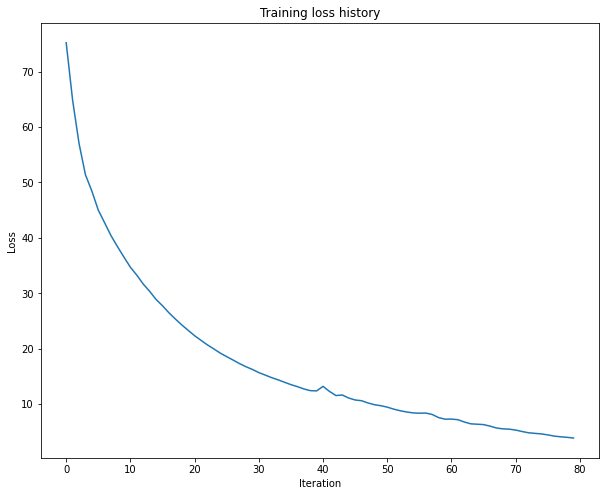

In [ ]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Again I will simply odify the [`sample`](#scrollTo=v0M8Dq5NEOxN) method in module `CaptioningRNN` to handle the case where `self.cell_type` is `attention`.

### Train the net
Now, I will perform the training on the entire training set.

learning rate is:  0.001
(Epoch 0 / 60) loss: 50.1922 time per epoch: 7.0s
(Epoch 1 / 60) loss: 47.2045 time per epoch: 6.9s
(Epoch 2 / 60) loss: 42.8975 time per epoch: 7.0s
(Epoch 3 / 60) loss: 39.2331 time per epoch: 7.0s
(Epoch 4 / 60) loss: 36.3114 time per epoch: 7.0s
(Epoch 5 / 60) loss: 33.8685 time per epoch: 7.0s
(Epoch 6 / 60) loss: 31.7168 time per epoch: 7.1s
(Epoch 7 / 60) loss: 29.7247 time per epoch: 7.1s
(Epoch 8 / 60) loss: 27.7728 time per epoch: 7.0s
(Epoch 9 / 60) loss: 25.8799 time per epoch: 7.0s
(Epoch 10 / 60) loss: 24.0229 time per epoch: 7.0s
(Epoch 11 / 60) loss: 22.2640 time per epoch: 7.0s
(Epoch 12 / 60) loss: 20.7698 time per epoch: 7.0s
(Epoch 13 / 60) loss: 19.1661 time per epoch: 7.0s
(Epoch 14 / 60) loss: 17.9203 time per epoch: 7.0s
(Epoch 15 / 60) loss: 16.0299 time per epoch: 7.1s
(Epoch 16 / 60) loss: 14.7996 time per epoch: 7.1s
(Epoch 17 / 60) loss: 13.4877 time per epoch: 7.2s
(Epoch 18 / 60) loss: 12.3849 time per epoch: 7.0s
(Epoch 19 / 60) 

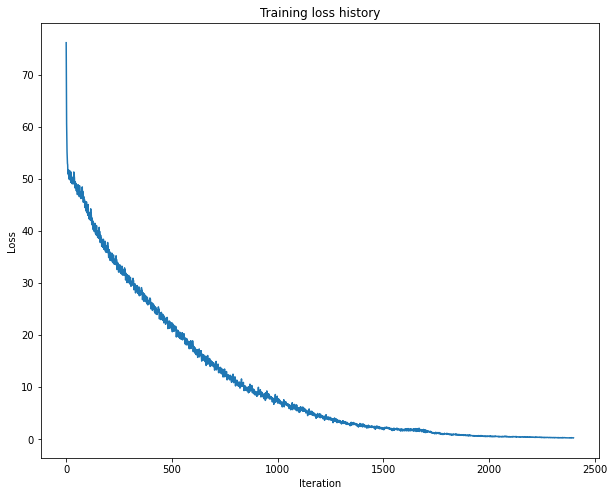

In [ ]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
attn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(attn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling and visualization
As with RNN and LSTM, the samples on training data should be very good; the samples on validation data will probably make less sense.

I will use the `attention_visualizer` function to visualize the attended regions per generated word. Note that sometimes the attended regions (brighter) might not make much sense particially due to our low resolution image input. In real applications, the attended regions are more accurate.

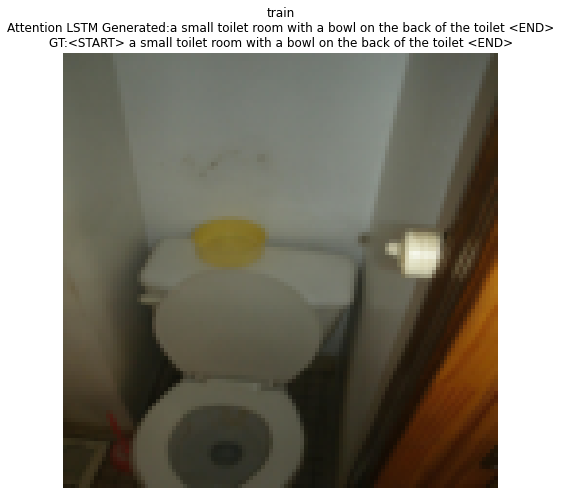

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


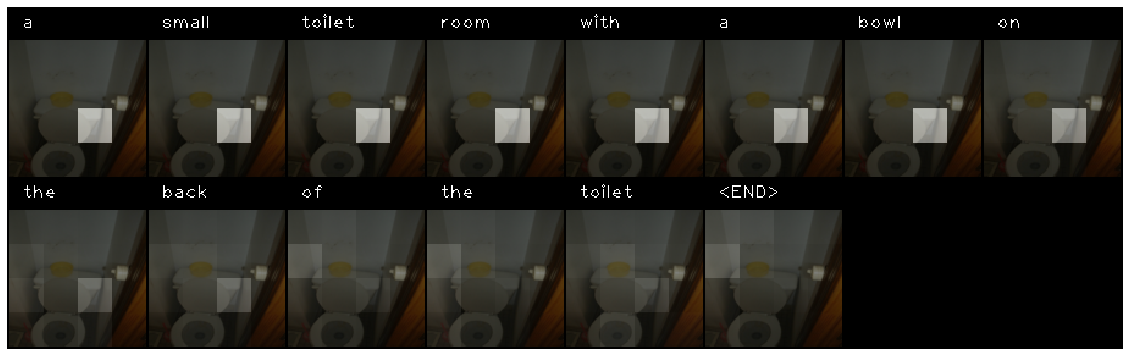

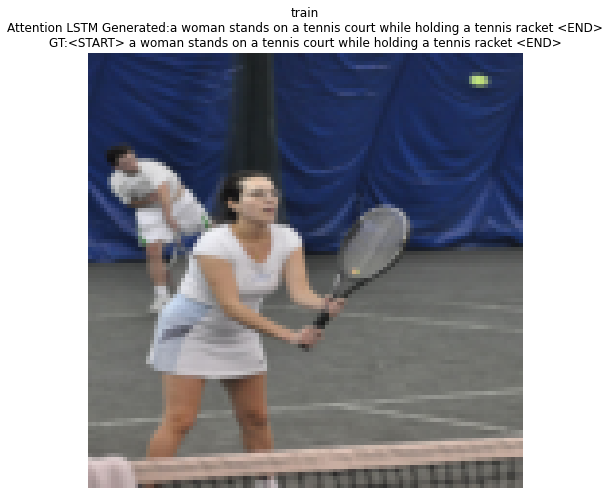

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


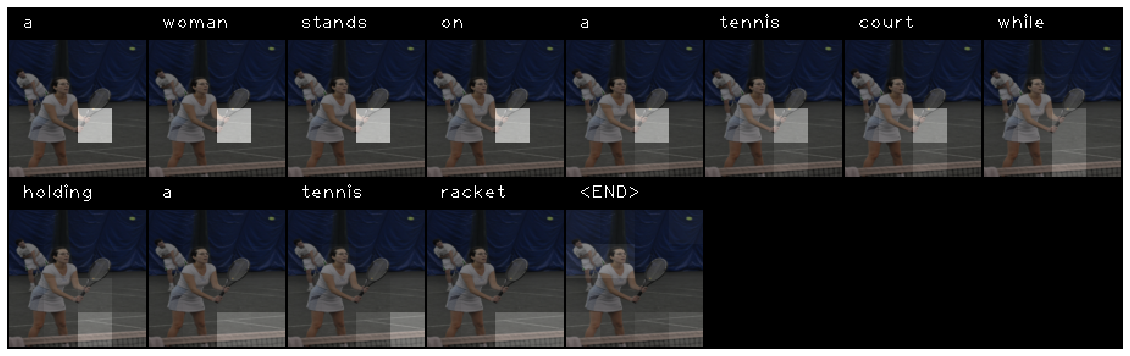

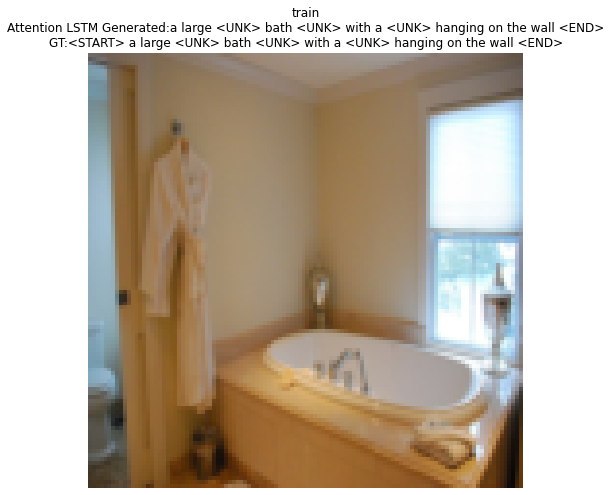

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


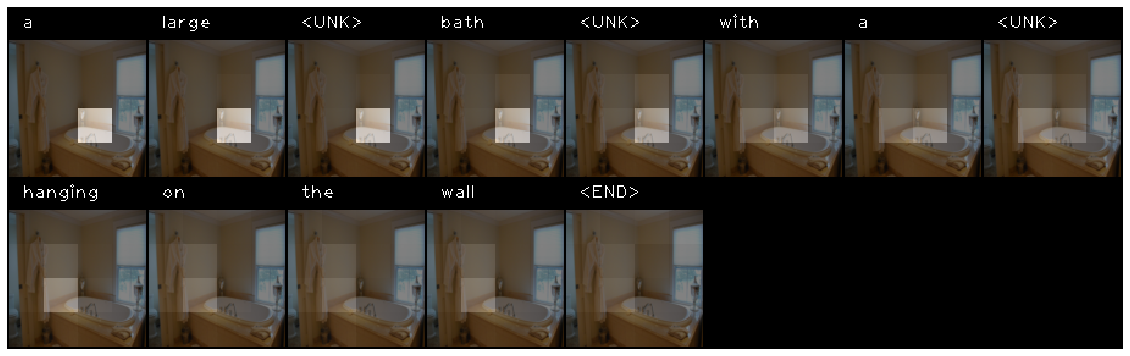

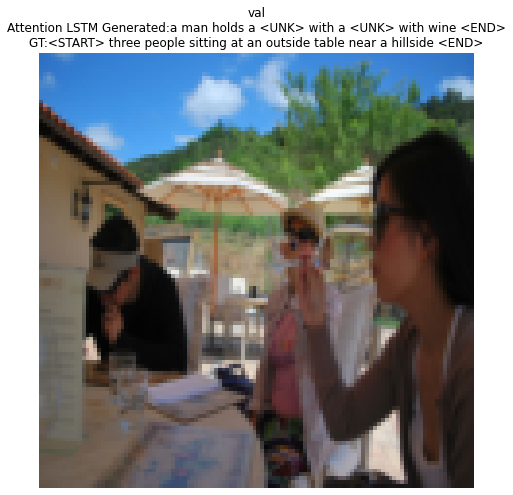

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


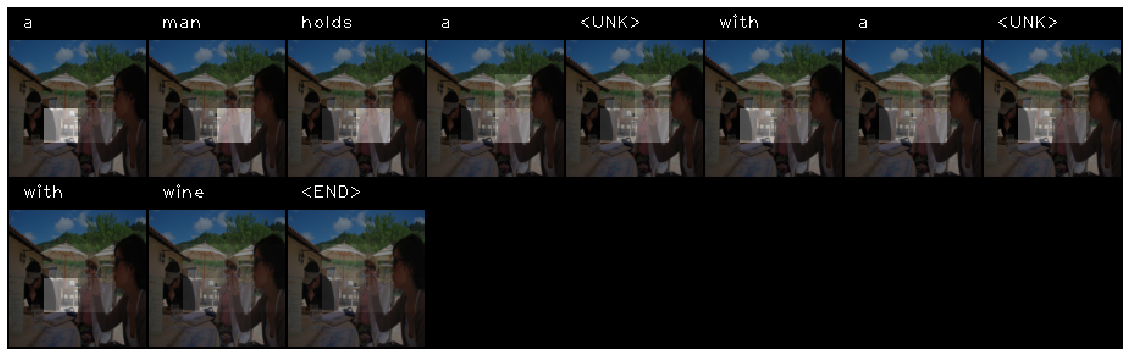

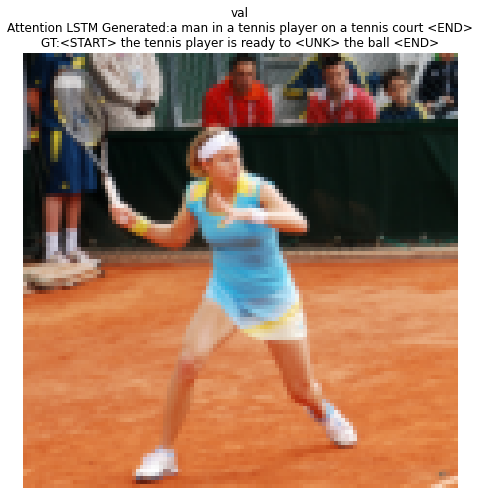

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


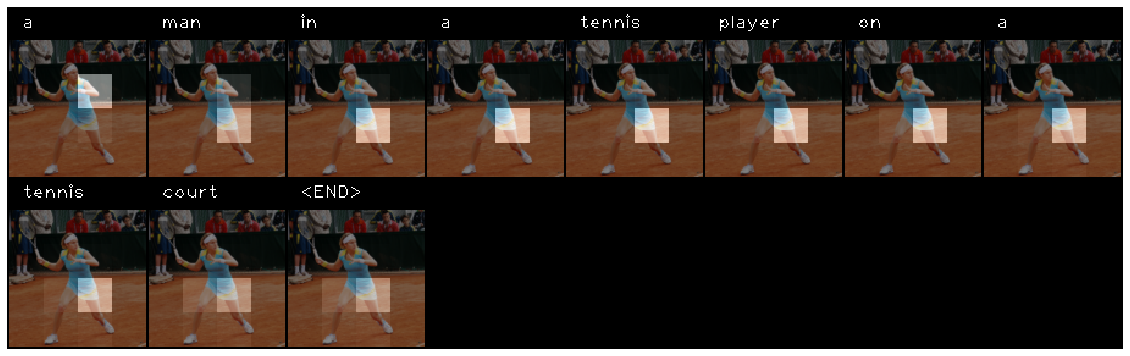

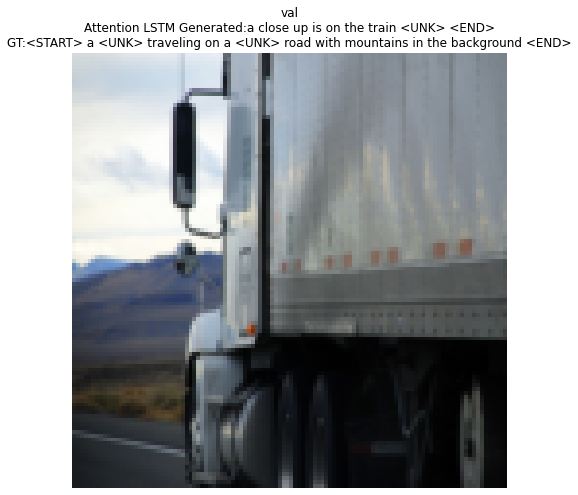

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


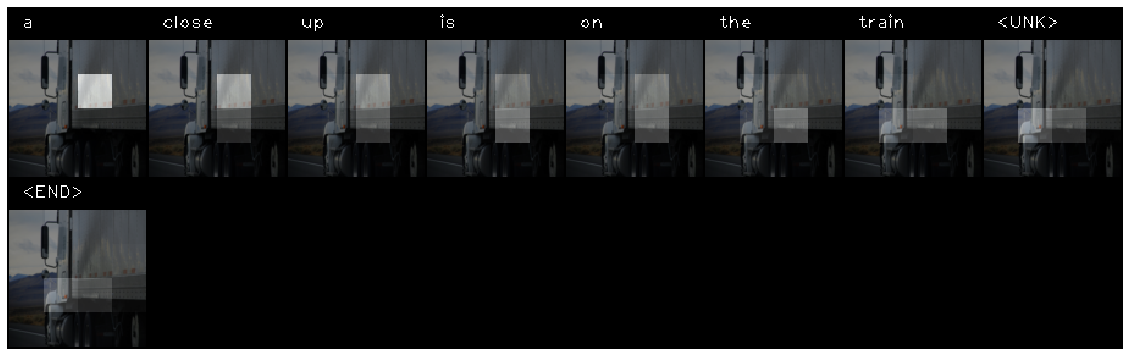

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.

batch_size = 3
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  attn_model.eval()
  generated_captions, attn_weights_all = attn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()
    
    tokens = generated_captions[i].split(' ')
    
    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)